# Training a Neural Network for Computer Model Emulation

### Import necessary libraries 

In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from calculations_load import *
from configurations import *

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'main_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/main', 'validation_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/validation', 'main_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/main.dat', 'validation_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/validation.dat', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 32

In [249]:
# Get all the observables list

nobs        =  0
observables =  []
obs_name    =  []

for obs, cent_list in obs_cent_list['Pb-Pb-2760'].items():
    observables.append(obs)
    n = np.array(cent_list).shape[0]
    for i in cent_list:
        obs_name.append(f'{obs}_{i}')
    #self._slices[obs] = slice(self.nobs, self.nobs + n)
    nobs += n

In [4]:
#prepare the directories for model design and outputs
#run this cell only once, or else it will hang!
#! sh prepare.sh

### Loading Computer Model inputs and outputs

In [244]:
system_str = 'Pb-Pb-2760'
design_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat'
design = pd.read_csv(design_file)
design = design.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_set)
design = design.drop(drop_indices)

#choose features (inputs)
#feature_cols = ['norm', 'trento_p'] #specific choices
feature_cols = design.keys().values #all of them 
n_features = len(feature_cols)

X = design[feature_cols]

n_design = SystemsInfo["Pb-Pb-2760"]["n_design"]
npt = n_design - len(delete_design_pts_set)
obs = 'dNch_deta' #choose the observable we want to emulate

Y = np.array([])

for pt in range(npt):
    for obs in active_obs_list['Pb-Pb-2760']:
        Y = np.append( Y, trimmed_model_data[system_str][pt, idf][obs]['mean'][:], axis=0)
Y = Y.reshape(X.shape[0], -1)

In [9]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 17)
Y.shape : (485, 110)


## Splitting the inputs and outputs into a training and testing set

Then, scaling all of the inputs and outputs to (0, 1)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

#X_scaler = StandardScaler().fit(X_train)
#Y_scaler = StandardScaler().fit(Y_train)
X_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
Y_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(Y_train)

X_train_sc = X_scaler.transform(X_train)
X_test_sc = X_scaler.transform(X_test)

Y_train_sc = Y_scaler.transform(Y_train)
Y_test_sc = Y_scaler.transform(Y_test)

### The cell below constructs the neural network

In [155]:
n_hidden = 0 # number of hidden layers

model = keras.Sequential()
model.add(layers.Dense(50, input_dim=X.shape[1], activation='tanh'))
for n in range(n_hidden):
    model.add(layers.Dense(20, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(Y.shape[1], activation='tanh'))
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 50)                900       
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 110)               5610      
Total params: 6,510
Trainable params: 6,510
Non-trainable params: 0
_________________________________________________________________


In [256]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout
dropout_rate = 0.8
def model_fn():
    inputs = Input(shape=(X.shape[1],))
    x = Dense(50, activation='tanh')(inputs)
    x = Dropout(dropout_rate)(x, training=True)
    x = Dense(Y.shape[1], activation='tanh')(x)
   # x = Dropout(dropout_rate)(x, training=True)
    outputs = x
    
    model = Model(inputs, outputs)
#model.compile(loss="mean_squared_error", optimizer='adam')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [257]:
# compile the keras model
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model=model_fn()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 17)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                900       
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 110)               5610      
Total params: 6,510
Trainable params: 6,510
Non-trainable params: 0
_________________________________________________________________


In [258]:
model.fit(X_train_sc, Y_train_sc, epochs=500, batch_size=50)

Epoch 1/500
388/388 [==============================] - 0s 494us/step - loss: 0.4203 - accuracy: 0.0129
Epoch 2/500
388/388 [==============================] - 0s 36us/step - loss: 0.4025 - accuracy: 0.0103
Epoch 3/500
388/388 [==============================] - 0s 47us/step - loss: 0.3742 - accuracy: 0.0206
Epoch 4/500
388/388 [==============================] - 0s 37us/step - loss: 0.3518 - accuracy: 0.0103
Epoch 5/500
388/388 [==============================] - 0s 43us/step - loss: 0.3316 - accuracy: 0.0206
Epoch 6/500
388/388 [==============================] - 0s 44us/step - loss: 0.3082 - accuracy: 0.0206
Epoch 7/500
388/388 [==============================] - 0s 40us/step - loss: 0.2991 - accuracy: 0.0103
Epoch 8/500
388/388 [==============================] - 0s 42us/step - loss: 0.2785 - accuracy: 0.0129
Epoch 9/500
388/388 [==============================] - 0s 32us/step - loss: 0.2603 - accuracy: 0.0103
Epoch 10/500
388/388 [==============================] - 0s 49us/step - loss: 0.23

388/388 [==============================] - 0s 28us/step - loss: 0.0476 - accuracy: 0.2294
Epoch 81/500
388/388 [==============================] - 0s 27us/step - loss: 0.0474 - accuracy: 0.2113
Epoch 82/500
388/388 [==============================] - 0s 29us/step - loss: 0.0473 - accuracy: 0.2320
Epoch 83/500
388/388 [==============================] - 0s 28us/step - loss: 0.0457 - accuracy: 0.2113
Epoch 84/500
388/388 [==============================] - 0s 28us/step - loss: 0.0493 - accuracy: 0.2165
Epoch 85/500
388/388 [==============================] - 0s 31us/step - loss: 0.0463 - accuracy: 0.1933
Epoch 86/500
388/388 [==============================] - 0s 27us/step - loss: 0.0486 - accuracy: 0.2268
Epoch 87/500
388/388 [==============================] - 0s 28us/step - loss: 0.0489 - accuracy: 0.2577
Epoch 88/500
388/388 [==============================] - 0s 29us/step - loss: 0.0470 - accuracy: 0.2139
Epoch 89/500
388/388 [==============================] - 0s 27us/step - loss: 0.0479 - 

388/388 [==============================] - 0s 29us/step - loss: 0.0426 - accuracy: 0.2861
Epoch 160/500
388/388 [==============================] - 0s 27us/step - loss: 0.0425 - accuracy: 0.2680
Epoch 161/500
388/388 [==============================] - 0s 32us/step - loss: 0.0454 - accuracy: 0.2242
Epoch 162/500
388/388 [==============================] - 0s 30us/step - loss: 0.0434 - accuracy: 0.2320
Epoch 163/500
388/388 [==============================] - 0s 44us/step - loss: 0.0428 - accuracy: 0.2423
Epoch 164/500
388/388 [==============================] - 0s 39us/step - loss: 0.0445 - accuracy: 0.2474
Epoch 165/500
388/388 [==============================] - 0s 39us/step - loss: 0.0434 - accuracy: 0.2345
Epoch 166/500
388/388 [==============================] - 0s 34us/step - loss: 0.0455 - accuracy: 0.2345
Epoch 167/500
388/388 [==============================] - 0s 32us/step - loss: 0.0436 - accuracy: 0.2423
Epoch 168/500
388/388 [==============================] - 0s 32us/step - loss: 

388/388 [==============================] - 0s 32us/step - loss: 0.0437 - accuracy: 0.2680
Epoch 238/500
388/388 [==============================] - 0s 32us/step - loss: 0.0433 - accuracy: 0.2732
Epoch 239/500
388/388 [==============================] - 0s 30us/step - loss: 0.0450 - accuracy: 0.2835
Epoch 240/500
388/388 [==============================] - 0s 30us/step - loss: 0.0424 - accuracy: 0.2655
Epoch 241/500
388/388 [==============================] - 0s 31us/step - loss: 0.0460 - accuracy: 0.2500
Epoch 242/500
388/388 [==============================] - 0s 33us/step - loss: 0.0464 - accuracy: 0.2552
Epoch 243/500
388/388 [==============================] - 0s 31us/step - loss: 0.0432 - accuracy: 0.2320
Epoch 244/500
388/388 [==============================] - 0s 31us/step - loss: 0.0436 - accuracy: 0.2500
Epoch 245/500
388/388 [==============================] - 0s 31us/step - loss: 0.0439 - accuracy: 0.2706
Epoch 246/500
388/388 [==============================] - 0s 31us/step - loss: 

388/388 [==============================] - 0s 29us/step - loss: 0.0429 - accuracy: 0.2474
Epoch 316/500
388/388 [==============================] - 0s 31us/step - loss: 0.0411 - accuracy: 0.2345
Epoch 317/500
388/388 [==============================] - 0s 31us/step - loss: 0.0427 - accuracy: 0.2655
Epoch 318/500
388/388 [==============================] - 0s 31us/step - loss: 0.0457 - accuracy: 0.2552
Epoch 319/500
388/388 [==============================] - 0s 32us/step - loss: 0.0466 - accuracy: 0.2448
Epoch 320/500
388/388 [==============================] - 0s 31us/step - loss: 0.0442 - accuracy: 0.2345
Epoch 321/500
388/388 [==============================] - 0s 33us/step - loss: 0.0423 - accuracy: 0.2345
Epoch 322/500
388/388 [==============================] - 0s 33us/step - loss: 0.0433 - accuracy: 0.2423
Epoch 323/500
388/388 [==============================] - 0s 31us/step - loss: 0.0425 - accuracy: 0.2577
Epoch 324/500
388/388 [==============================] - 0s 29us/step - loss: 

388/388 [==============================] - 0s 31us/step - loss: 0.0443 - accuracy: 0.2474
Epoch 394/500
388/388 [==============================] - 0s 29us/step - loss: 0.0459 - accuracy: 0.2526
Epoch 395/500
388/388 [==============================] - 0s 31us/step - loss: 0.0447 - accuracy: 0.2655
Epoch 396/500
388/388 [==============================] - 0s 32us/step - loss: 0.0455 - accuracy: 0.2397
Epoch 397/500
388/388 [==============================] - 0s 27us/step - loss: 0.0438 - accuracy: 0.2268
Epoch 398/500
388/388 [==============================] - 0s 29us/step - loss: 0.0422 - accuracy: 0.2577
Epoch 399/500
388/388 [==============================] - 0s 31us/step - loss: 0.0411 - accuracy: 0.2552
Epoch 400/500
388/388 [==============================] - 0s 31us/step - loss: 0.0449 - accuracy: 0.2371
Epoch 401/500
388/388 [==============================] - 0s 29us/step - loss: 0.0427 - accuracy: 0.2655
Epoch 402/500
388/388 [==============================] - 0s 30us/step - loss: 

388/388 [==============================] - 0s 28us/step - loss: 0.0450 - accuracy: 0.2629
Epoch 472/500
388/388 [==============================] - 0s 28us/step - loss: 0.0446 - accuracy: 0.2397
Epoch 473/500
388/388 [==============================] - 0s 28us/step - loss: 0.0436 - accuracy: 0.2552
Epoch 474/500
388/388 [==============================] - 0s 26us/step - loss: 0.0455 - accuracy: 0.2526
Epoch 475/500
388/388 [==============================] - 0s 29us/step - loss: 0.0418 - accuracy: 0.2655
Epoch 476/500
388/388 [==============================] - 0s 29us/step - loss: 0.0435 - accuracy: 0.2732
Epoch 477/500
388/388 [==============================] - 0s 26us/step - loss: 0.0441 - accuracy: 0.2552
Epoch 478/500
388/388 [==============================] - 0s 26us/step - loss: 0.0421 - accuracy: 0.2500
Epoch 479/500
388/388 [==============================] - 0s 25us/step - loss: 0.0409 - accuracy: 0.2835
Epoch 480/500
388/388 [==============================] - 0s 27us/step - loss: 

In [259]:
import numpy as np
predictions = []
sample_size = 1000
for t in range(sample_size):
    predictions.append(model.predict(X_test_sc))
   # pred_array = np.array(predictions)
   # print(pred_array.shape)
prediction_df = pd.DataFrame()
prediction_std= pd.DataFrame()
pred_array = np.array(predictions)
prediction_df= np.mean(pred_array,axis=0)
prediction_sd= np.std(pred_array,axis=0)
#prediction_df['std'] = pred_array.std(axis=0)

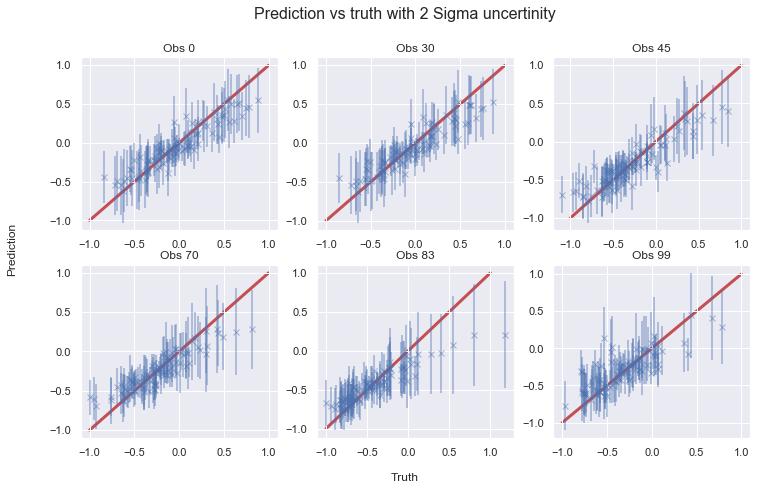

In [260]:
truth = np.linspace(-1, 1, 100)
obs_indices = [0, 30, 45, 70, 83, 99]

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('Prediction vs truth with 2 Sigma uncertinity', fontsize=16)
fig.text(0.5, 0.04, 'Truth', ha='center')
fig.text(0.04, 0.5, 'Prediction', va='center', rotation='vertical')
for i, obs_ind in enumerate(obs_indices):
    ax = axes.flatten()[i]
    ax.set_title("Obs " + str(obs_ind))
    ax.plot(truth, truth, c='r', lw=3, zorder=-1)
    ax.errorbar(Y_test_sc[:, obs_ind], prediction_df[:, obs_ind],yerr=2*prediction_sd[:,obs_ind],alpha=0.5,fmt='x')

In [236]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(Y_test_sc,prediction_df)

In [237]:
coefficient_of_dermination

0.8507124646247438